In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus


p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
h5 = 'cerberus_annot_triplets.h5'
ab = '../talon/human_talon_abundance.tsv'
filt_ab = 'cerberus_filtered_abundance.tsv'
major_set = 'swan/isos_sample_gene_90.tsv'
mm_tissues = ['adrenal gland', 'heart',
              'muscle', 'brain', 'pgp1_excite_neuron',
              'pgp1_astro', 'h9_osteocyte']

In [3]:
ca = cerberus.read('cerberus_annot_triplets.h5')
c_dict, order = get_biosample_colors()
c_dict[np.nan] = 'k'

mm_tissues = ['adrenal gland', 'heart',
              'muscle', 'brain', 'pgp1_excite_neuron',
              'pgp1_astro', 'h9_osteocyte']
mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2'}
subset = {'source': ['v40', 'obs_det', 'sample_major']}

## % genes in each sector per sample

In [4]:
def plot_perc_genes_per_sector(ca, source, fname):
    df = ca.triplets.loc[ca.triplets.source == source]
    df = compute_genes_per_sector(df, ['sample'])

    c_dict, order = get_sector_colors()

    # plotting
    sns.set_context('paper', font_scale=1.8)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=(5,4))

    ax = sns.swarmplot(data=df, y='perc', x='sector', hue='sector', 
                       palette=c_dict, order=order,
                       size=2.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ylabel = '% genes in each sector / sample'
    xlabel = ''
    xlim=None

    if xlim:
        _ = ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0,xlim))
    else:
        _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    xticks = [cat.capitalize() if cat not in ['tss', 'tes'] else cat.upper() for cat in order]
    ax.set_xticklabels(xticks)
    ax.legend_.remove()
    
    plt.savefig(fname, dpi=500, bbox_inches='tight')
    

In [5]:
source = 'sample_det'
obs_source = 'obs_det'
fname = 'figures/test'
# plot_perc_genes_per_sector(ca, source, 
#     'figures/swarm_genes_per_sector_sample.pdf')

       source              gid  n_tss  n_tes  n_ic  n_iso  splicing_ratio  \
0  sample_det  ENSG00000000003    1.0    5.0   6.0   18.0             2.0   
1  sample_det  ENSG00000000419    1.0    4.0   8.0   11.0             3.2   
2  sample_det  ENSG00000000457    1.0    2.0   3.0    4.0             2.0   
3  sample_det  ENSG00000000460    2.0    1.0   3.0    4.0             2.0   
4  sample_det  ENSG00000001036    1.0    4.0   6.0   11.0             2.4   

      gname sample    gene_tpm  
0    TSPAN6  caco2  347.757385  
1      DPM1  caco2  126.812943  
2     SCYL3  caco2   10.705085  
3  C1orf112  caco2   17.822382  
4     FUCA2  caco2  261.958191  
    source              gid  n_tss  n_tes  n_ic  n_iso  splicing_ratio  \
0  obs_det  ENSG00000000003    1.0    6.0   9.0   28.0        2.571429   
1  obs_det  ENSG00000000005    1.0    1.0   1.0    1.0        1.000000   
2  obs_det  ENSG00000000419    2.0    4.0   9.0   15.0        3.000000   
3  obs_det  ENSG00000000457    3.0    4.0  

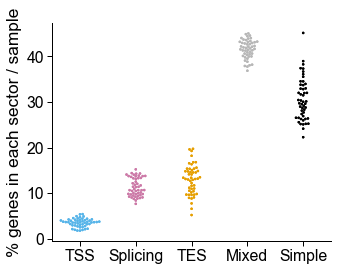

In [6]:
# def plot_perc_genes_per_sector(ca, source, fname):
df = ca.triplets.loc[ca.triplets.source == source]
print(df.head())
df = compute_genes_per_sector(df, ['sample'])
# df['sector_source'] = df['sector']
obs_df = ca.triplets.loc[ca.triplets.source == obs_source]
print(obs_df.head())
obs_df = compute_genes_per_sector(obs_df, [])
# obs_df['sector_source'] = 'obs'

c_dict, order = get_sector_colors()
# c_dict['obs'] = 'k'

# plotting
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(5,4))

# just the data
ax = sns.swarmplot(data=df, y='perc', x='sector', hue='sector', 
                   palette=c_dict, order=order,
                   size=2.5)
# obs data
ax = sns.swarmplot(data=df, y='perc', x='sector', hue='sector', 
                   palette=c_dict, order=order,
                   size=2.5)
# ax = sns.swarmplot(data=df, y='perc', x='sector', hue='sector', 
#                    palette=c_dict, order=order,
#                    size=5, ax=ax, marker='^')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ylabel = '% genes in each sector / sample'
xlabel = ''
xlim=None

if xlim:
    _ = ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0,xlim))
else:
    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
xticks = [cat.capitalize() if cat not in ['tss', 'tes'] else cat.upper() for cat in order]
ax.set_xticklabels(xticks)
ax.legend_.remove()

plt.savefig(fname, dpi=500, bbox_inches='tight')
    


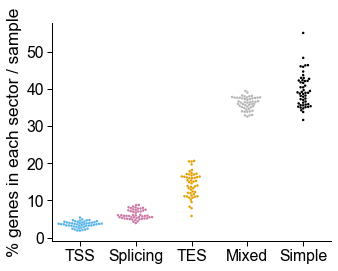

In [21]:
source = 'sample_major'
obs_source = 'obs_major'
plot_perc_genes_per_sector(ca, source, 
    'figures/swarm_genes_per_sector_sample_major.pdf')

## % genes in each sector per sample split by tissues / cell lines

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus


p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
ca = cerberus.read('cerberus_annot_triplets.h5')

In [13]:
def plot_perc_genes_per_sector_sample_type(ca, source, fname):

    df = ca.triplets.loc[ca.triplets.source == source]

    # assign each sample a sample type (tissue or cell line)
    cell_lines = get_sample_datasets('cell_line', groupby='sample')
    tissues = get_sample_datasets('tissue', groupby='sample')
    df.loc[df['sample'].isin(cell_lines), 'sample_type'] = 'cell_line'
    df.loc[df['sample'].isin(tissues), 'sample_type'] = 'tissue'

    df = compute_genes_per_sector(df, ['sample', 'sample_type'])

    c_dict, order = get_tissue_cell_line_colors()

    # plotting
    sns.set_context('paper', font_scale=1.8)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=(5,4))

    _, order = get_sector_colors()
    
    ax = sns.swarmplot(data=df, x='sector', y='perc',
                  hue='sample_type', size=2.0,
                  palette=c_dict, dodge=True, 
                  order=order)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ylabel = '% genes in each sector / sample'
    xlabel = ''
    xlim=None

    if xlim:
        _ = ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0,xlim))
    else:
        _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    xticks = [cat.capitalize() if cat not in ['tss', 'tes'] else cat.upper() for cat in order]
    _ = ax.set_xticklabels(xticks)

    plt.savefig(fname, dpi=500, bbox_inches='tight')
    

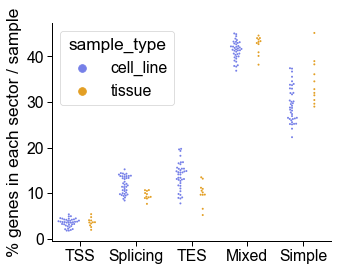

In [14]:
source = 'sample_det'
plot_perc_genes_per_sector_sample_type(ca, source,
        'figures/swarm_genes_per_sector_sample_sample_type.pdf')

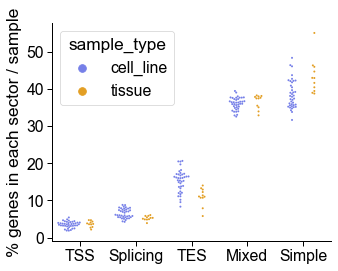

In [15]:
source = 'sample_major'
plot_perc_genes_per_sector_sample_type(ca, source,
        'figures/swarm_genes_per_sector_sample_sample_type_major.pdf')

## IDK

     sector  n_genes       perc
0     mixed     7397  42.950877
1    simple     5511  31.999768
2  splicing     1578   9.162699
3       tes     1811  10.515620
4       tss      925   5.371037


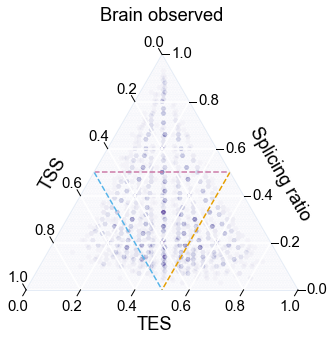

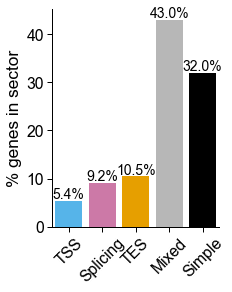

In [76]:
# brain 
temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'sample_det', 'sample': 'brain'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Brain observed',
            size_scale=0.5,
            density_cbar=False,
            fname='figures/simplex_brain_obs.pdf')
plot_genes_per_sector(temp)

In [ ]:
# brain 
temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'sample_major', 'sample': 'brain'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Brain observed major',
            size_scale=1,
            density_cbar=False,
            fname='figures/simplex_brain_obs_major.pdf')
plot_genes_per_sector(temp)

     sector  n_genes       perc
0     mixed     6239  43.209364
1    simple     3829  26.518457
2  splicing     1983  13.733638
3       tes     1863  12.902556
4       tss      525   3.635986


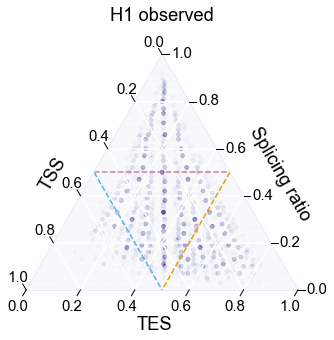

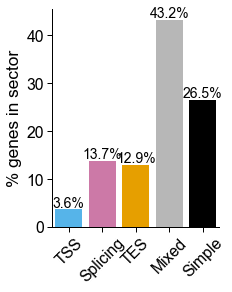

In [75]:
# h1 
temp = ca.plot_simplex(top='splicing_ratio',
            subset={'source': 'sample_det', 'sample': 'h1'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='H1 observed',
            size_scale=0.5,
            density_cbar=False,
            fname='figures/simplex_h1_obs.pdf')
plot_genes_per_sector(temp)

In [67]:
# which genes become TES-high in the brain after being ES cells? 
samples = ['h1', 'brain'] 
sources = ['sample_det']
temp = ca.triplets.loc[(ca.triplets['sample'].isin(samples))&(ca.triplets['source'].isin(sources))]
temp = assign_gisx_sector(temp)
temp = temp[['gid', 'gname', 'sample', 'sector']]

df = pd.DataFrame()
for i, s in enumerate(samples): 
    if i == 0:
        df = temp.loc[temp['sample'] == s]
    else:
        df = df.merge(temp.loc[temp['sample'] == s], how='outer',
                      on=['gid', 'gname'], suffixes=('_'+samples[i-1], '_'+s))
    
    




In [70]:
df.loc[(df['sector_h1']!='tes')&(df['sector_brain']=='tes')]
df.loc[(df['sector_h1']=='tes')&(df['sector_brain']=='tes')]

,gid,gname,sample_h1,sector_h1,sample_brain,sector_brain
9,ENSG00000001461,NIPAL3,h1,tes,brain,tes
11,ENSG00000001561,ENPP4,h1,tes,brain,tes
41,ENSG00000004455,AK2,h1,tes,brain,tes
46,ENSG00000004700,RECQL,h1,tes,brain,tes
52,ENSG00000004897,CDC27,h1,tes,brain,tes
...,...,...,...,...,...,...
14270,ENSG00000277283,ENSG00000277283,h1,tes,brain,tes
14272,ENSG00000277443,MARCKS,h1,tes,brain,tes
14284,ENSG00000278053,DDX52,h1,tes,brain,tes
14294,ENSG00000278311,GGNBP2,h1,tes,brain,tes


In [71]:
def plot_genes_per_sector(df):
    
    temp = df.copy(deep=True)
    
    # count the number of genes in each sector
    temp = compute_genes_per_sector(temp, [])
    # temp = assign_gisx_sector(temp)
    # temp = temp[['gid', 'sector']].groupby('sector').count().reset_index()
    # temp.rename({'gid': 'n_genes'}, axis=1, inplace=True)
    # temp['perc'] = (temp.n_genes/temp.n_genes.sum())*100
    # print(temp)
        
    c_dict, order = get_sector_colors()
    
    # plotting
    sns.set_context('paper', font_scale=1.8)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=(3,4))
    ax = sns.barplot(data=temp, y='perc', x='sector', palette=c_dict, order=order, saturation=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    xlabel = ''
    ylabel = '% genes in sector'
    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    xticks = [cat.capitalize() if cat not in ['tss', 'tes'] else cat.upper() for cat in order]
    ax.tick_params(axis="x", rotation=45)    
    ax.set_xticklabels(xticks)

    def add_perc_2(ax):
        ylim = ax.get_ylim()[1]
        n_cats = len(ax.patches)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(p.get_height())
            x = p.get_x() + p.get_width() / 2
            # x = p.get_x() + p.get_width() / 2 - 0.3
            # x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
            y = p.get_y() + p.get_height() + ylim*0.01
            ax.annotate(percentage, (x, y), size=14, horizontalalignment='center')

    add_perc_2(ax)